In [10]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

class LSUNBedroomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Traverse the directory to get image paths
        for subdir, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(('png', 'jpg', 'jpeg')):
                    self.image_paths.append(os.path.join(subdir, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

path = '../Dataset/bedroom/'
# Create dataset
dataset = LSUNBedroomDataset(root_dir='../Dataset/bedroom/', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [16]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

# Instantiate the model
model = UNet2DModel(
    sample_size=64,
    in_channels=3,
    out_channels=3,
    layers_per_block=1,
    block_out_channels=(32, 64, 128),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D")
)

# Set up the noise scheduler

# Training parameters
optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 10
device = torch.device("mps")
model.to(device)

In [32]:
class SMLDScheduler:
    def __init__(self, num_train_timesteps):
        self.num_train_timesteps = num_train_timesteps

    def add_noise(self, images, noise, timesteps):
        alphas = self.get_alpha(timesteps).unsqueeze(1).unsqueeze(1).unsqueeze(1)
        return images + alphas * noise

    def get_alpha(self, t):
        # Convert t to a tensor if it's an integer
        if isinstance(t, int):
            t = torch.tensor([t], device="mps")
        # Ensure t is a long tensor
        t = t.long()
        return torch.linspace(1e-4, 0.02, self.num_train_timesteps).to(t.device)[t]
noise_scheduler = SMLDScheduler(num_train_timesteps=2500)

In [12]:
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()

        batch = batch.to(device)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch.size(0),), device=device).long()
        noise = torch.randn_like(batch)
        noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)
        
        noise_pred = model(noisy_images, timesteps).sample
        
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed. Loss: {loss.item()}")

Training Epoch 1/10: 100%|██████████| 4737/4737 [33:42<00:00,  2.34it/s]


Epoch 1 completed. Loss: 0.480094850063324


Training Epoch 2/10: 100%|██████████| 4737/4737 [33:27<00:00,  2.36it/s]


Epoch 2 completed. Loss: 0.435265451669693


Training Epoch 3/10: 100%|██████████| 4737/4737 [33:33<00:00,  2.35it/s]


Epoch 3 completed. Loss: 0.46607980132102966


Training Epoch 4/10: 100%|██████████| 4737/4737 [33:33<00:00,  2.35it/s]


Epoch 4 completed. Loss: 0.4288356304168701


Training Epoch 5/10: 100%|██████████| 4737/4737 [33:31<00:00,  2.35it/s]


Epoch 5 completed. Loss: 0.4475679099559784


Training Epoch 6/10: 100%|██████████| 4737/4737 [33:31<00:00,  2.35it/s]


Epoch 6 completed. Loss: 0.4585038125514984


Training Epoch 7/10: 100%|██████████| 4737/4737 [33:30<00:00,  2.36it/s]


Epoch 7 completed. Loss: 0.46587812900543213


Training Epoch 8/10: 100%|██████████| 4737/4737 [33:31<00:00,  2.35it/s]


Epoch 8 completed. Loss: 0.36762535572052


Training Epoch 9/10: 100%|██████████| 4737/4737 [33:31<00:00,  2.36it/s]


Epoch 9 completed. Loss: 0.42690297961235046


Training Epoch 10/10: 100%|██████████| 4737/4737 [33:22<00:00,  2.37it/s]

Epoch 10 completed. Loss: 0.38720205426216125


In [13]:
# Save the model
torch.save(model.state_dict(), "smld_bedroom_64x64_10_epoch.pth")

In [33]:
import os
import torch
from tqdm import tqdm
from torchvision.utils import save_image

model.eval()
num_images = 5
generated_images = []

with torch.no_grad():
    for _ in tqdm(range(num_images), desc="Generating Images"):
        noisy_image = torch.randn(1, 3, 64, 64, device=device)
        for t in reversed(range(noise_scheduler.num_train_timesteps)):
            timesteps = torch.full((1,), t, device=device, dtype=torch.long)
            model_output = model(noisy_image, timesteps)
            
            noisy_image = noise_scheduler.add_noise(model_output.sample, noisy_image, t)
        
        generated_image = noisy_image.squeeze(0).cpu()
        generated_images.append(generated_image)

# Saving generated images
output_dir = f"generated_images_smld_{num_epochs}_epochs"
os.makedirs(output_dir, exist_ok=True)

for idx, image in enumerate(generated_images):
    save_image(image, f"{output_dir}/generated_image_{idx+1}.png")

print(f"{num_images} images generated and saved in {output_dir}")

Generating Images: 100%|██████████| 5/5 [03:11<00:00, 38.32s/it]

5 images generated and saved in generated_images_smld_10_epochs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


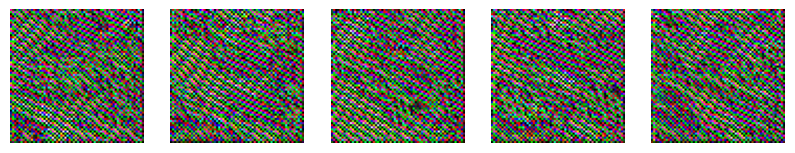

In [35]:
# plot 50 images from the generated images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(generated_images[i].permute(1, 2, 0))
    plt.axis('off')
plt.show()